# Helpmate AI

## Install Required Libraries

In [2]:
# Install all the required libraries

!pip install pdfplumber tiktoken openai chromaDB sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

## Embedding Layer

### Reading a PDF file and exploring it through pdfplumber

In [5]:
base_path = "/content/drive/MyDrive/GenAI_Course_Master/Helpmate-AI/data/"
file_name = "Principal-Sample-Life-Insurance-Policy.pdf"
file_path = f"{base_path}{file_name}"

In [6]:
# Reae pdf file and explore its content
# Open the PDF file

with pdfplumber.open(file_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[0]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

DOROTHEA GLAUSE S655
RHODE ISLAND JOHN DOE 01/01/2014
711 HIGH STREET
GEORGE RI 02903
GROUP POLICY FOR:
RHODE ISLAND JOHN DOE
ALL MEMBERS
Group Member Life Insurance
Print Date: 07/16/2014


In [7]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [8]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [9]:
# Process the PDF file
print(f"...Processing {file_path}")

# Call the function to extract the text from the PDF
extracted_text = extract_text_from_pdf(file_path)

# Convert the extracted list to a PDF, and add a column to store document names
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
extracted_text_df['Document Name'] = file_name

...Processing /content/drive/MyDrive/GenAI_Course_Master/Helpmate-AI/data/Principal-Sample-Life-Insurance-Policy.pdf


In [10]:
extracted_text_df.head()

Page No.                                          Page_Text  \
0   Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
1   Page 2                 This page left blank intentionally   
2   Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
3   Page 4                 This page left blank intentionally   
4   Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   

                                Document Name  
0  Principal-Sample-Life-Insurance-Policy.pdf  
1  Principal-Sample-Life-Insurance-Policy.pdf  
2  Principal-Sample-Life-Insurance-Policy.pdf  
3  Principal-Sample-Life-Insurance-Policy.pdf  
4  Principal-Sample-Life-Insurance-Policy.pdf

In [11]:
extracted_text_df["Page_Text"][2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [12]:
extracted_text_df['Text_Length'] = extracted_text_df['Page_Text'].apply(lambda x: len(x.split(' ')))

In [13]:
extracted_text_df.Text_Length

0      30
1       5
2     230
3       5
4     110
     ... 
59    285
60    418
61    322
62      5
63      8
Name: Text_Length, Length: 64, dtype: int64

In [14]:
# Retain only the rows with a text length of at least 10

extracted_text_df = extracted_text_df.loc[extracted_text_df['Text_Length'] >= 10]
extracted_text_df.head()

Page No.                                          Page_Text  \
0   Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
2   Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
4   Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
5   Page 6  TABLE OF CONTENTS PART I - DEFINITIONS PART II...   
6   Page 7  Section A – Eligibility Member Life Insurance ...   

                                Document Name  Text_Length  
0  Principal-Sample-Life-Insurance-Policy.pdf           30  
2  Principal-Sample-Life-Insurance-Policy.pdf          230  
4  Principal-Sample-Life-Insurance-Policy.pdf          110  
5  Principal-Sample-Life-Insurance-Policy.pdf          153  
6  Principal-Sample-Life-Insurance-Policy.pdf          176

In [15]:
# Store the metadata for each page in a separate column

extracted_text_df['Metadata'] = extracted_text_df.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

<ipython-input-15-5423c0e3f979>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_text_df['Metadata'] = extracted_text_df.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [16]:
extracted_text_df.head()

Page No.                                          Page_Text  \
0   Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
2   Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
4   Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
5   Page 6  TABLE OF CONTENTS PART I - DEFINITIONS PART II...   
6   Page 7  Section A – Eligibility Member Life Insurance ...   

                                Document Name  Text_Length  \
0  Principal-Sample-Life-Insurance-Policy.pdf           30   
2  Principal-Sample-Life-Insurance-Policy.pdf          230   
4  Principal-Sample-Life-Insurance-Policy.pdf          110   
5  Principal-Sample-Life-Insurance-Policy.pdf          153   
6  Principal-Sample-Life-Insurance-Policy.pdf          176   

                                            Metadata  
0  {'Policy_Name': 'Principal-Sample-Life-Insuran...  
2  {'Policy_Name': 'Principal-Sample-Life-Insuran...  
4  {'Policy_Name': 'Principal-Sample-Life-Insuran...  
5  {'Policy_Name': 'Principal-Sample-Life-Insuran...  
6  {'Policy_Name': 'Principal-Sample-Life-Insuran...

In [17]:
extracted_text_df.Metadata[0]

{'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Page_No.': 'Page 1'}

## Generation Layer

### Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's text-embedding-ada-002 model, and store them in a ChromaDB collection.

In [18]:

# Set the API key
api_key_base_path = "/content/drive/MyDrive/GenAI_Course_Master/"
# filepath = "/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/"

with open(api_key_base_path + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [19]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [20]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/MyDrive/GenAI_Course_Master/Helpmate-AI/data/ChromaDB'

In [21]:
import chromadb

client = chromadb.PersistentClient()

# Set up the embedding function using the OpenAI embedding model
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents
insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma
documents_list = extracted_text_df["Page_Text"].tolist()
metadata_list = extracted_text_df['Metadata'].tolist()

# Add the documents and metadata to the collection alongwith generic integer IDs.
# You can also feed the metadata information as IDs by combining the policy name and page no.
insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [22]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.022495761513710022,
   0.01878996379673481,
   -0.027245447039604187,
   -0.03126441314816475,
   -0.0036797013599425554,
   0.02787178009748459,
   0.0008306240779347718,
   0.023630989715456963,
   -0.016623899340629578,
   0.004332130774855614,
   -0.005252055823802948,
   0.004087469540536404,
   -0.006282893940806389,
   0.0233047753572464,
   -0.011234832927584648,
   0.031081732362508774,
   0.0029016793705523014,
   -0.02470097318291664,
   0.030716370791196823,
   0.007822627201676369,
   0.006439477205276489,
   0.018933497369289398,
   0.009649429470300674,
   0.012520118616521358,
   -0.012467923574149609,
   -0.009453700855374336,
   0.017889611423015594,
   -0.021699799224734306,
   0.023604892194271088,
   0.0030386894941329956,
   0.013303033076226711,
   -0.014588318765163422,
   -0.03358706086874008,
   -0.041103046387434006,
   -0.008481580764055252,
   0.013635772280395031,
   -0.0025461053010076284,
   -0.003901527263224

In [23]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [24]:
cache_collection.peek()

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None}

### Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [25]:
# Read the user query

query = input()

Tell me about PRINCIPAL LIFE INSURANCE COMPANY


In [26]:
query

'Tell me about PRINCIPAL LIFE INSURANCE COMPANY'

In [27]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
  query_texts=query,
  n_results=1
)

In [28]:
cache_results

{'ids': [[]],
 'distances': [[]],
 'metadatas': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None}

In [29]:
results = insurance_collection.query(
  query_texts=query,
  n_results=10
)

In [30]:
results.items()

dict_items([('ids', [['2', '1', '17', '15', '18', '39', '14', '44', '21', '43']]), ('distances', [[0.25462809849304024, 0.29389627167052784, 0.34830159254478493, 0.35217070634327113, 0.3639580082800607, 0.3652673401262095, 0.3684065573929667, 0.3814458029921738, 0.38191835143241853, 0.38233768893721165]]), ('metadatas', [[{'Page_No.': 'Page 5', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 3', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 20', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 18', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 21', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 42', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 17', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 47', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 24'

In [31]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(10):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [52]:
def get_semantic_search(query):
  # Implementing Cache in Semantic Search

  # Set a threshold for cache search
  threshold = 0.2

  ids = []
  documents = []
  distances = []
  metadatas = []
  results_df = pd.DataFrame()


  # If the distance is greater than the threshold, then return the results from the main collection.

  if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
    # Query the collection against the user query and return the top 10 results
    results = insurance_collection.query(
    query_texts=query,
    n_results=10
    )

    # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
    # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
    Keys = []
    Values = []

    for key, val in results.items():
      if val is None:
        continue
      for i in range(10):
        Keys.append(str(key)+str(i))
        Values.append(str(val[0][i]))


    cache_collection.add(
        documents= [query],
        ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
        metadatas = dict(zip(Keys, Values))
    )

    print("Not found in cache. Found in main collection.")

    result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
    results_df = pd.DataFrame.from_dict(result_dict)
    results_df

  # If the distance is, however, less than the threshold, you can return the results from cache

  elif cache_results['distances'][0][0] <= threshold:
    cache_result_dict = cache_results['metadatas'][0][0]

    # Loop through each inner list and then through the dictionary
    for key, value in cache_result_dict.items():
        if 'ids' in key:
            ids.append(value)
        elif 'documents' in key:
            documents.append(value)
        elif 'distances' in key:
            distances.append(value)
        elif 'metadatas' in key:
            metadatas.append(value)

    print("Found in cache!")

    # Create a DataFrame
    results_df = pd.DataFrame({
      'IDs': ids,
      'Documents': documents,
      'Distances': distances,
      'Metadatas': metadatas
    })

  return results_df


In [32]:
results_df

Metadatas  \
0  {'Page_No.': 'Page 5', 'Policy_Name': 'Princip...   
1  {'Page_No.': 'Page 3', 'Policy_Name': 'Princip...   
2  {'Page_No.': 'Page 20', 'Policy_Name': 'Princi...   
3  {'Page_No.': 'Page 18', 'Policy_Name': 'Princi...   
4  {'Page_No.': 'Page 21', 'Policy_Name': 'Princi...   
5  {'Page_No.': 'Page 42', 'Policy_Name': 'Princi...   
6  {'Page_No.': 'Page 17', 'Policy_Name': 'Princi...   
7  {'Page_No.': 'Page 47', 'Policy_Name': 'Princi...   
8  {'Page_No.': 'Page 24', 'Policy_Name': 'Princi...   
9  {'Page_No.': 'Page 46', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  
0  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   0.254628   2  
1  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   0.293896   1  
2  Section B - Premiums Article 1 - Payment Respo...   0.348302  17  
3  c . a copy of the form which contains the stat...   0.352171  15  
4  b . on any date the definition of Member or De...   0.363958  18  
5  Section F - Individual Purchase Rights Article...   0.365267  39  
6  a. be actively engaged in business for profit ...   0.368407  14  
7  M ember's death, the Death Benefits Payable ma...   0.381446  44  
8  T he Principal may terminate the Policyholder'...   0.381918  21  
9  PART IV - BENEFITS Section A - Member Life Ins...   0.382338  43

### Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

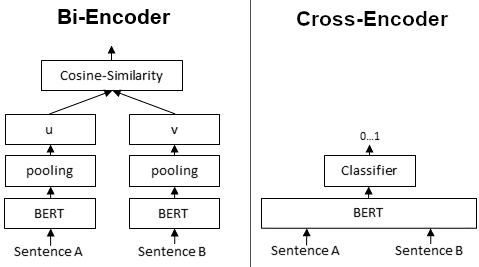

<br>

In [33]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [34]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [35]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [36]:
scores

array([  3.84676 , -11.252879], dtype=float32)

In [37]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder

cross_inputs = [[query, response] for response in results_df['Documents']]

In [38]:
# Generate the cross_encoder scores for these pairs

cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [39]:
cross_rerank_scores

array([ 4.3698726,  1.746396 , -3.8135662, -3.4520411, -2.5203912,
       -2.7314587, -7.3080997, -2.4725742, -6.7044153, -5.060638 ],
      dtype=float32)

In [40]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [41]:
results_df

Metadatas  \
0  {'Page_No.': 'Page 5', 'Policy_Name': 'Princip...   
1  {'Page_No.': 'Page 3', 'Policy_Name': 'Princip...   
2  {'Page_No.': 'Page 20', 'Policy_Name': 'Princi...   
3  {'Page_No.': 'Page 18', 'Policy_Name': 'Princi...   
4  {'Page_No.': 'Page 21', 'Policy_Name': 'Princi...   
5  {'Page_No.': 'Page 42', 'Policy_Name': 'Princi...   
6  {'Page_No.': 'Page 17', 'Policy_Name': 'Princi...   
7  {'Page_No.': 'Page 47', 'Policy_Name': 'Princi...   
8  {'Page_No.': 'Page 24', 'Policy_Name': 'Princi...   
9  {'Page_No.': 'Page 46', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  \
0  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   0.254628   2   
1  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   0.293896   1   
2  Section B - Premiums Article 1 - Payment Respo...   0.348302  17   
3  c . a copy of the form which contains the stat...   0.352171  15   
4  b . on any date the definition of Member or De...   0.363958  18   
5  Section F - Individual Purchase Rights Article...   0.365267  39   
6  a. be actively engaged in business for profit ...   0.368407  14   
7  M ember's death, the Death Benefits Payable ma...   0.381446  44   
8  T he Principal may terminate the Policyholder'...   0.381918  21   
9  PART IV - BENEFITS Section A - Member Life Ins...   0.382338  43   

   Reranked_scores  
0         4.369873  
1         1.746396  
2        -3.813566  
3        -3.452041  
4        -2.520391  
5        -2.731459  
6        -7.308100  
7        -2.472574  
8        -6.704415  
9        -5.060638

In [42]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

Metadatas  \
0  {'Page_No.': 'Page 5', 'Policy_Name': 'Princip...   
1  {'Page_No.': 'Page 3', 'Policy_Name': 'Princip...   
2  {'Page_No.': 'Page 20', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  \
0  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   0.254628   2   
1  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   0.293896   1   
2  Section B - Premiums Article 1 - Payment Respo...   0.348302  17   

   Reranked_scores  
0         4.369873  
1         1.746396  
2        -3.813566

In [43]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

Metadatas  \
0  {'Page_No.': 'Page 5', 'Policy_Name': 'Princip...   
1  {'Page_No.': 'Page 3', 'Policy_Name': 'Princip...   
7  {'Page_No.': 'Page 47', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  \
0  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   0.254628   2   
1  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   0.293896   1   
7  M ember's death, the Death Benefits Payable ma...   0.381446  44   

   Reranked_scores  
0         4.369873  
1         1.746396  
7        -2.472574

In [44]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [45]:
top_3_RAG

Documents  \
0  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
1  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
7  M ember's death, the Death Benefits Payable ma...   

                                           Metadatas  
0  {'Page_No.': 'Page 5', 'Policy_Name': 'Princip...  
1  {'Page_No.': 'Page 3', 'Policy_Name': 'Princip...  
7  {'Page_No.': 'Page 47', 'Policy_Name': 'Princi...

In [53]:
def get_top_3_after_re_ranking(results_df):

  # Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
  cross_inputs = [[query, response] for response in results_df['Documents']]

  # Generate the cross_encoder scores for these pairs
  cross_rerank_scores = cross_encoder.predict(cross_inputs)

  # Store the rerank_scores in results_df
  results_df['Reranked_scores'] = cross_rerank_scores

  # Return the top 3 results after reranking
  top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
  top_3_rerank[:3]

  top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
  return top_3_RAG


### Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [46]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [47]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [49]:
print(f"Query : {query}")
print(f"Response :")
print("\n".join(response))

Query : Tell me about PRINCIPAL LIFE INSURANCE COMPANY
Response :
The Principal Life Insurance Company, as described in the document snippets provided, is referenced as part of an insurance policy. While the details in the snippets do not provide an in-depth overview of the company itself, they do mention the company within the context of insurance policies.

If you are looking for specific information about the Principal Life Insurance Company, it would be advisable to refer to the complete documents mentioned in the snippets to gain a comprehensive understanding. The provided snippets mention the policy name and the corresponding page numbers where the information can be found.

For further details about the Principal Life Insurance Company, kindly refer to the complete documents with the following details:

1. Policy Name: Principal Life Insurance Company
   Page Number: 5

Please review the complete document on Page 5 for more detailed information about the Principal Life Insurance

In [50]:
query = input()

what are Premium Rates


In [54]:
def get_context(query):
  result_df = get_semantic_search(query)
  top_3_RAG = get_top_3_after_re_ranking(result_df)
  return top_3_RAG

In [55]:
def execute_query(query):
  df = get_context(query)
  response = generate_response(query, df)
  return response

In [56]:
query

'what are Premium Rates'

In [60]:
response = execute_query(query)

Not found in cache. Found in main collection.


In [61]:
print(f"Query : {query}")
print(f"Response :")
print("\n".join(response))

Query : what happen if I am failure to pay premium
Response :
If you fail to pay your insurance premium, the consequences can vary based on the specific policy terms. Typically, if you miss a premium payment, there is a grace period during which the policy remains in force. If the premium is not paid even after the grace period ends, the policy may lapse, and you may lose the insurance coverage and associated benefits.

Here is a more detailed breakdown from the available policy documents:

**Policy Name**: Principal Life Insurance Company - Policy Rider Group Insurance Policy

**Page Number**: Page 3

In case of failure to pay the premium, the policy may be at risk of lapsing. It's essential to refer to the specific terms and conditions outlined in your policy document to understand the exact consequences of non-payment and any available options for reinstatement.

If you require more detailed information, it is recommended to review the policy document provided for a comprehensive un

In [62]:
query = input()

what are Premium Rates


In [63]:
response = execute_query(query)
print(f"Query : {query}")
print(f"Response :")
print("\n".join(response))

Not found in cache. Found in main collection.
Query : what are Premium Rates
Response :
Premium rates refer to the amount of money an insurance company charges for coverage based on the risk factors associated with the insured individual or property. Premium rates are typically influenced by factors such as age, health condition, occupation, coverage amount, and past insurance claims history.

In the provided insurance documents, we find information related to premium rates in the policies offered by the Principal Life Insurance Company. The specific premium rates may vary depending on the type of policy, coverage amount, and the individual's personal circumstances.

Unfortunately, the detailed premium rates are not explicitly mentioned in the extracted document excerpts. To obtain accurate premium rate information, it is recommended to refer to the full policy documents where specific premium rates are outlined. You can search for terms like "Premium Rates" or "Cost of Insurance" in t

In [64]:
query = input()


what are Premium Rates


In [65]:
response = execute_query(query)

Not found in cache. Found in main collection.


In [66]:
print(f"Query : {query}")
print(f"Response :")
print("\n".join(response))

Query : what are Premium Rates
Response :
Premium Rates are the specific amounts of money that insurance companies charge for a particular insurance policy. These rates are typically paid on a regular basis, such as monthly or yearly, to maintain the insurance coverage. Premium rates can vary depending on factors such as the type of insurance, the coverage amount, the age and health of the insured individual, and other risk factors.

Relevant Information from Documents:
| Document Name                                | Page Number |                                         
|----------------------------------------------|-------------|                                       
| Principal Life Insurance Company            | Page 5      |                                       
| Policy Rider Group Insurance Policy          | Page 3      |                                        
| Member's death, Death Benefits Payable       | Page 47     |   

Citations:
1. Principal Life Insurance Company, 

In [68]:
query = input()

Tell me about PRINCIPAL LIFE INSURANCE COMPANY


In [69]:
response = execute_query(query)

Not found in cache. Found in main collection.


In [70]:
print(f"Query : {query}")
print(f"Response :")
print("\n".join(response))

Query : Tell me about PRINCIPAL LIFE INSURANCE COMPANY
Response :
PRINCIPAL LIFE INSURANCE COMPANY offers insurance services as described in the policy document. The document may contain detailed information about the insurance coverage, benefits, terms, and conditions provided by the company. If you are looking for specific details such as types of insurance offered, coverage limits, premium rates, or any other specific information, I recommend referring to the policy document for precise details.

Here is a summary of key information extracted from the policy document about PRINCIPAL LIFE INSURANCE COMPANY:

| Information                         |
|-------------------------------------|
| Insurance Company Name              | PRINCIPAL LIFE INSURANCE COMPANY      |
| Mentioned Page Number(s)            | Page 5                               |

Please refer to the mentioned document located on page 5 for more detailed information about PRINCIPAL LIFE INSURANCE COMPANY.

Citations:
- P